In [1]:
import datetime
from pathlib import Path

import shutil

import pandas as pd
import numpy as np
import geopandas as gp
import skimage

from pdf2image import convert_from_path, convert_from_bytes

from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

## Make png of pdf

In [2]:
first_page = 12
last_page = 17

In [3]:
temp_folder = "tmp"

try:
    shutil.rmtree(temp_folder)
except Exception:
    pass

Path(temp_folder).mkdir(exist_ok=True)

tmp/ecea1d64-fc09-4c61-bf1b-b45c223f8a8c-13.png
tmp/ecea1d64-fc09-4c61-bf1b-b45c223f8a8c-15.png
tmp/ecea1d64-fc09-4c61-bf1b-b45c223f8a8c-17.png


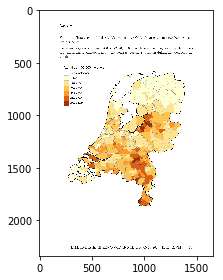

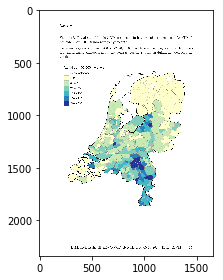

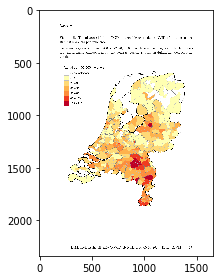

In [4]:
report_fp = "../../reports/COVID-19_epidemiological_report_20200605.pdf"

images = convert_from_path(
    report_fp, 
    output_folder=temp_folder, 
    fmt='png',
    first_page=first_page,
    last_page=last_page,
)

image_files = dict(zip(["Totaal_diff", "Totaal", "Ziekenhuisopname_diff", "Ziekenhuisopname", "Overleden_diff", "Overleden"], sorted(Path("tmp").glob("*.png"))))

for key, image_file in image_files.items():
    
    if key.endswith("_diff"):
        continue
    
    print(image_file)
    plt.figure()
    image = skimage.io.imread(image_file)
    skimage.io.imshow(image)

## Static variables

In [59]:
# DATE = datetime.date(2020, 5, 2)

DATE = datetime.datetime.strptime(report_fp, '../../reports/COVID-19_epidemiological_report_%Y%m%d.pdf').date()

MAP = "Totaal"

COLOR_BINS = [
    (0, 0), 
    (0, 140), 
    (140, 250), 
    (250, 355), 
    (355, 490), 
    (490, 680), 
    (680, 1025)
]

MAP = "Ziekenhuisopname"

COLOR_BINS = [
    (0, 0), 
    (0, 40), 
    (40,70), 
    (70,105), 
    (105, 150), 
    (150, 210), 
    (210, 335)
]

MAP = "Overleden"

COLOR_BINS = [
    (0, 0), 
    (0, 20), 
    (20, 35), 
    (35, 55), 
    (55, 85), 
    (85, 135), 
    (135, 210)
]


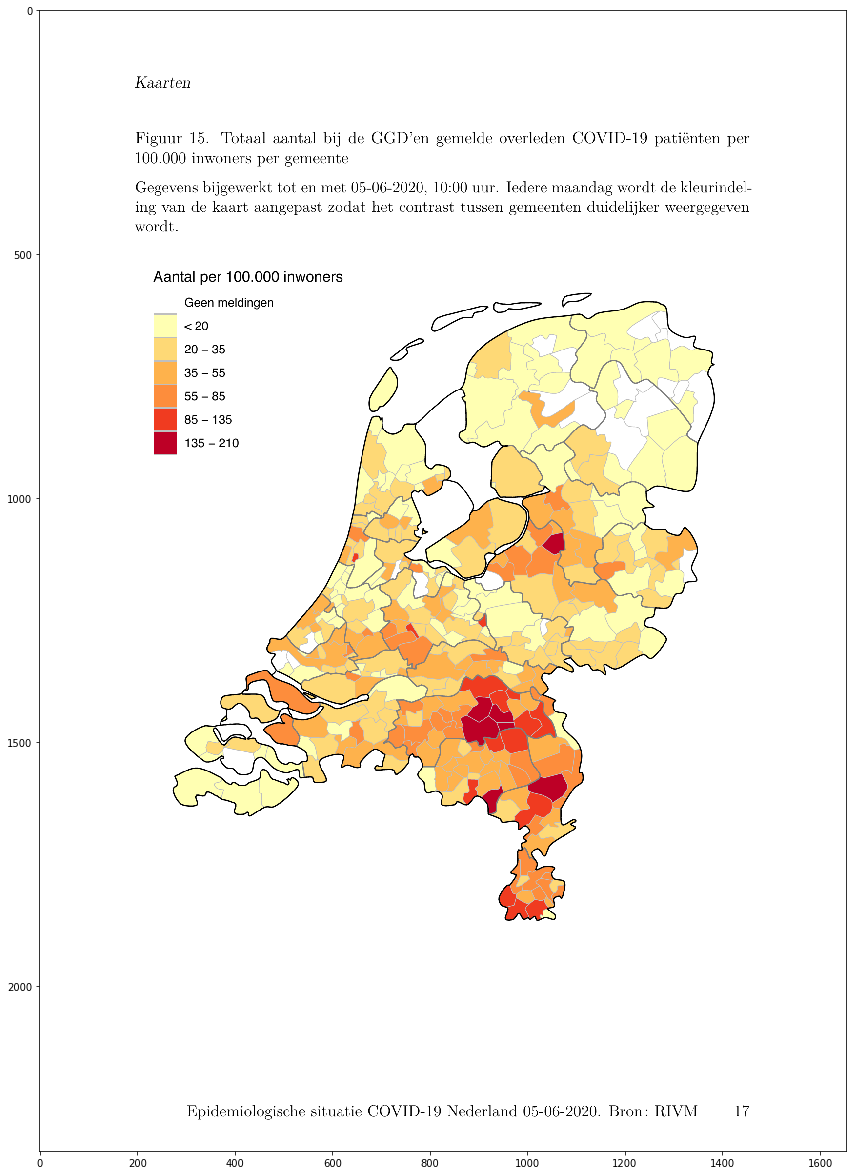

In [60]:
plt.figure(figsize=[12,20])

image = skimage.io.imread(image_files[MAP])

skimage.io.imshow(image)

## Make a bounding box for the pdf image

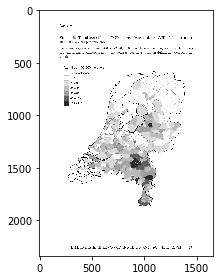

In [61]:
image = skimage.io.imread(image_files[MAP], as_gray=True)

skimage.io.imshow(image)

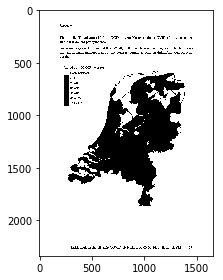

In [62]:
image_bw = image.copy()
image_bw[image_bw < 1] = 0

skimage.io.imshow(image_bw)

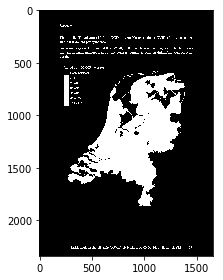

In [63]:
image_invert = 1 - image_bw

skimage.io.imshow(image_invert)

<BarContainer object of 2339 artists>

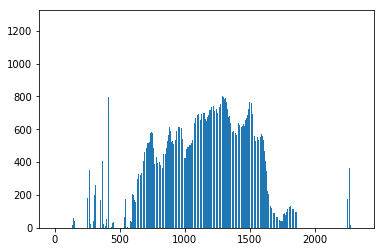

In [64]:
# check the side view
plt.bar(np.arange(image_bw.shape[0]), image_invert.sum(axis=1))

In [65]:
# let's assume the center of the page matches NL somehow
x_center = int(image_bw.shape[0]/2)
y_center = int(image_bw.shape[1]/2)

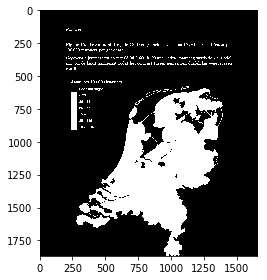

In [66]:
x_bottom = x_center+np.argmax(image_invert[x_center:, :].sum(axis=1)==0)

skimage.io.imshow(image_invert[:x_bottom, :])

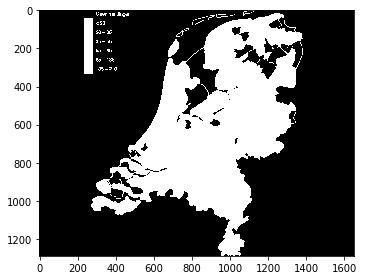

In [67]:
x_top = x_center - np.argmax(np.flipud(image_invert[0:x_center, y_center:]).sum(axis=1)==0)

skimage.io.imshow(image_invert[x_top:x_bottom, :])

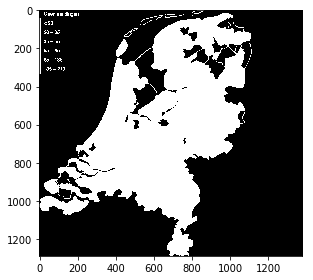

In [68]:
y_left = np.argmax(image_invert[x_center:x_bottom, :].sum(axis=0)>0)
skimage.io.imshow(image_invert[x_top:x_bottom, y_left:])

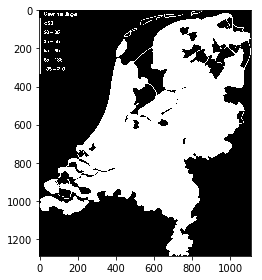

In [69]:
y_right = y_center + np.argmax(image_invert[x_top:x_bottom, y_center:].sum(axis=0)==0)

skimage.io.imshow(image_invert[x_top:x_bottom, y_left:y_right])

In [70]:
bbox_pdf = [x_top, y_left, x_bottom, y_right]
bbox_pdf

[579, 273, 1868, 1386]

## Transform center of mass to image size

In [71]:
gemeente_namen = pd.read_csv('../../ext/Gemeenten_alfabetisch_2019.csv', sep=";")
gemeenten = gp.read_file("../../ext/gemeente-2019.geojson")

gemeenten['centroid_x'] = gemeenten['geometry'].centroid.x
gemeenten['centroid_y'] = gemeenten['geometry'].centroid.y

gemeenten = gemeenten.merge(gemeente_namen[['Gemeentecode', 'Gemeentenaam', 'Provincienaam']], 
                            left_on='Gemnr',
                            right_on='Gemeentecode')

# gemeenten = gemeenten[['Gemeentenaam', 'Gemeentecode', 'centroid_x', 'centroid_y']]

# manual corrections
gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_x"] - 3000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_y"] - 3000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Delfzijl", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Delfzijl", "centroid_y"] - 3000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Bloemendaal", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Bloemendaal", "centroid_y"] + 5000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Berg en Dal", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Berg en Dal", "centroid_x"] - 2500
gemeenten.loc[gemeenten["Gemeentenaam"] == "Rotterdam", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Rotterdam", "centroid_x"] + 11000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Heerenveen", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Heerenveen", "centroid_x"] - 4000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Hardinxveld-Giessendam", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Hardinxveld-Giessendam", "centroid_x"] - 1000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Geldrop-Mierlo", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Geldrop-Mierlo", "centroid_y"] + 1000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Borne", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Borne", "centroid_y"] + 1000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Reimerswaal", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Reimerswaal", "centroid_y"] - 1500
gemeenten.loc[gemeenten["Gemeentenaam"] == "Bergen (L.)", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Bergen (L.)", "centroid_x"] - 1000




In [72]:
bbox_geojson = [
    gemeenten.bounds.minx.min(), 
    gemeenten.bounds.miny.min(), 
    gemeenten.bounds.maxx.max(), 
    gemeenten.bounds.maxy.max()
]

bbox_geojson

[323325.0, 1232816.0, 587769.0, 1539244.0]

In [73]:
a = 1/(bbox_geojson[2] - bbox_geojson[0]) * (bbox_pdf[3] - bbox_pdf[1])

gemeenten_x_rescaled = bbox_pdf[1] + (gemeenten.centroid_x - bbox_geojson[0])*a
gemeenten_y_rescaled = (image.shape[0] - (image.shape[0] - bbox_pdf[2])) - ((gemeenten.centroid_y - bbox_geojson[1])*a)

## Map geojson and pdf

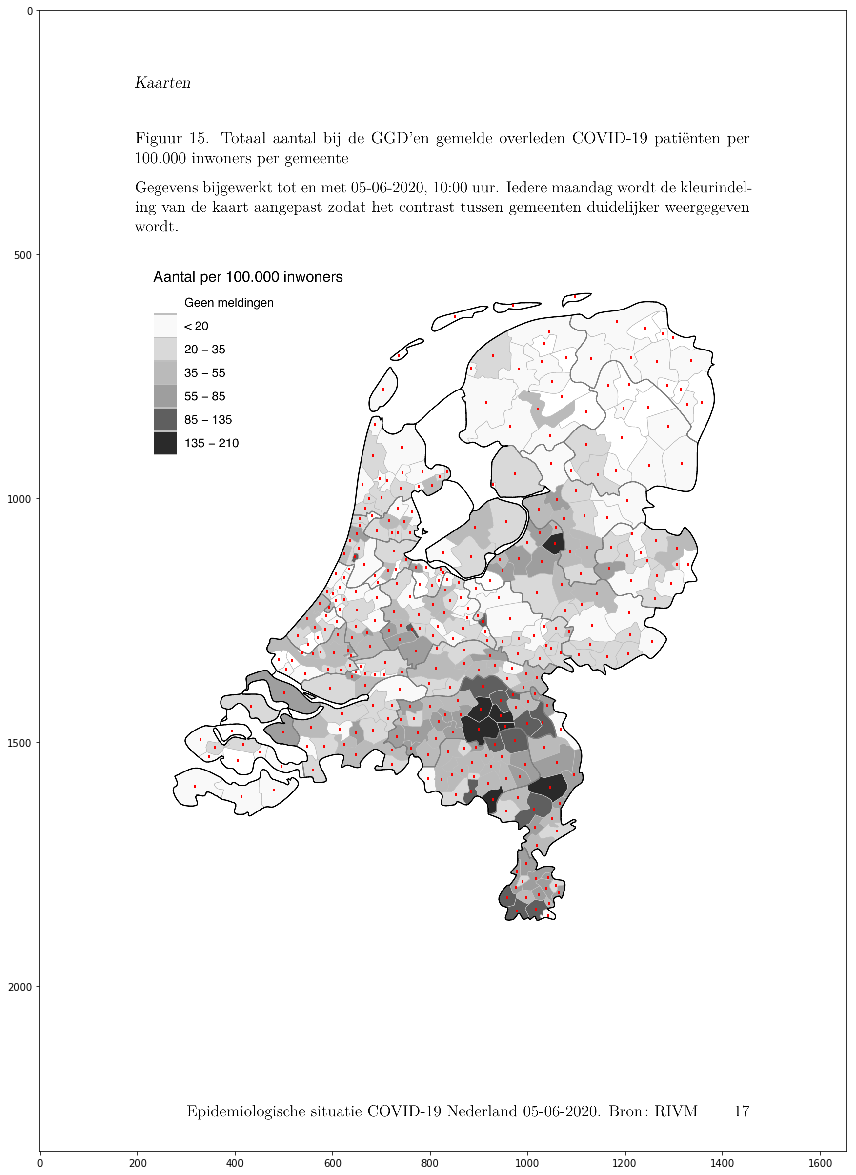

In [74]:
image_rbg = skimage.color.grey2rgb(image)

for i,x in enumerate(gemeenten_x_rescaled):
    
    image_rbg[
        int(gemeenten_y_rescaled[i]-3):int(gemeenten_y_rescaled[i]+3), 
        int(x)-2:int(x)+2, 
        0
    ] = 1 
    
    image_rbg[
        int(gemeenten_y_rescaled[i]-3):int(gemeenten_y_rescaled[i]+3), 
        int(x)-2:int(x)+2, 
        1
    ] = 0
    
    image_rbg[
        int(gemeenten_y_rescaled[i]-3):int(gemeenten_y_rescaled[i]+3), 
        int(x)-2:int(x)+2, 
        2
    ] = 0

plt.figure(figsize=[12,20])

skimage.io.imshow(image_rbg)


In [75]:
gemeenten["color_code"] = image[gemeenten_y_rescaled.astype(int), gemeenten_x_rescaled.astype(int)]

color_counts = gemeenten["color_code"].value_counts().sort_index(ascending=False)
color_counts

1.000000    27
0.978229    97
0.853822    98
0.732533    68
0.623372    43
0.374572    15
0.168244     7
Name: color_code, dtype: int64

In [76]:
# check if the colors map the values correctly
assert len(COLOR_BINS) == len(color_counts.index.values)

color_map = pd.DataFrame({
    "color_code": color_counts.index.values, 
    "Aantal_min": [x[0] for x in COLOR_BINS],
    "Aantal_max": [x[1] for x in COLOR_BINS],
})

color_map

,color_code,Aantal_min,Aantal_max
0,1.000000,0,0
1,0.978229,0,20
2,0.853822,20,35
3,0.732533,35,55
4,0.623372,55,85
5,0.374572,85,135
6,0.168244,135,210


In [77]:
gemeenten[np.round(gemeenten["color_code"], 3) == 0.843]
# gemeenten[np.round(gemeenten["color_code"], 3) == 0.548]

,OBJECTID,Gemeenten_,Shape_Leng,Shape_Area,Gemnr,geometry,centroid_x,centroid_y,Gemeentecode,Gemeentenaam,Provincienaam,color_code


In [78]:
new_data = gemeenten.merge(color_map, on="color_code")
new_data["Datum"] = str(DATE)
new_data["Type"] = MAP

new_data = new_data[["Datum", "Gemeentenaam", "Gemeentecode", "Provincienaam", "Type", "Aantal_min", "Aantal_max"]]
new_data

,Datum,Gemeentenaam,Gemeentecode,Provincienaam,Type,Aantal_min,Aantal_max
0,2020-06-05,Appingedam,3,Groningen,Overleden,0,0
1,2020-06-05,Delfzijl,10,Groningen,Overleden,0,0
2,2020-06-05,Loppersum,24,Groningen,Overleden,0,0
3,2020-06-05,Veendam,47,Groningen,Overleden,0,0
4,2020-06-05,Achtkarspelen,59,Friesland,Overleden,0,0
...,...,...,...,...,...,...,...
350,2020-06-05,Laarbeek,1659,Noord-Brabant,Overleden,85,135
351,2020-06-05,Landerd,1685,Noord-Brabant,Overleden,85,135
352,2020-06-05,Sint Anthonis,1702,Noord-Brabant,Overleden,85,135
353,2020-06-05,Gulpen-Wittem,1729,Limburg,Overleden,85,135


## Merge data in data file

In [79]:
def is_new_data(data):
    return data[(data["Datum"] == str(DATE)) & (data["Type"] == MAP)].shape[0] == 0


In [80]:
old_data = pd.read_csv(Path("..", "..", "data", "rivm_NL_covid19_municipality_range.csv"))

In [81]:
if is_new_data(old_data):
    
    full_data = old_data.append(new_data).copy()
    
    # sort full data
    full_data["Type_index"] = full_data["Type"].replace({"Totaal": 1, "Ziekenhuisopname": 2, "Overleden": 3})
    full_data.sort_values(["Datum", "Type_index", "Gemeentecode"], inplace=True)
    del full_data["Type_index"]
    
    full_data["Aantal_min"] = full_data["Aantal_min"].astype(np.float64)
    full_data["Aantal_max"] = full_data["Aantal_max"].astype(np.float64)

    full_data.to_csv(Path("..", "..", "data", "rivm_NL_covid19_municipality_range.csv"), index=False)

In [82]:
full_data

,Datum,Gemeentenaam,Gemeentecode,Provincienaam,Type,Aantal_min,Aantal_max
0,2020-03-26,Appingedam,3,Groningen,Overleden,0.0,0.0
1,2020-03-26,Delfzijl,10,Groningen,Overleden,0.0,0.0
2,2020-03-26,Groningen,14,Groningen,Overleden,0.0,0.0
3,2020-03-26,Loppersum,24,Groningen,Overleden,0.0,0.0
4,2020-03-26,Almere,34,Flevoland,Overleden,0.0,0.0
...,...,...,...,...,...,...,...
220,2020-06-05,Hoeksche Waard,1963,Zuid-Holland,Overleden,20.0,35.0
121,2020-06-05,Het Hogeland,1966,Groningen,Overleden,0.0,20.0
122,2020-06-05,Westerkwartier,1969,Groningen,Overleden,0.0,20.0
123,2020-06-05,Noardeast-Fryslân,1970,Friesland,Overleden,0.0,20.0
